In [ ]:
from torch.utils.data import DataLoader
from datasets import Dataset
import pandas as pd
from preprocess_stock_data import process_apple_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Preprocess pipeline

In [2]:
file_path = 'HistoricalQuotes.csv'
df = process_apple_data(file_path)
df.head()

,Date,Last,Volume,Open,High,Low
2517,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500
2516,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771
2515,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057
2514,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2513,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2518 entries, 2517 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2518 non-null   datetime64[ns]
 1   Last    2518 non-null   float64       
 2   Volume  2518 non-null   int64         
 3   Open    2518 non-null   float64       
 4   High    2518 non-null   float64       
 5   Low     2518 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.7 KB


In [4]:
df.columns

Index(['Date', 'Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [5]:
df.shape

(2518, 6)

In [6]:
df.drop(columns=['Date','Volume'],inplace=True)

In [16]:
df.head()

,Last,Open,High,Low
2517,29.8557,29.3928,29.9286,29.3500
2516,29.8357,29.9900,30.1186,29.6771
2515,29.9043,29.8486,29.9814,29.7057
2514,30.1014,29.8971,30.1314,29.8043
2513,31.2786,30.7057,31.3857,30.6614


In [66]:
from sklearn.model_selection import train_test_split

# Apply scaling to the entire dataset first
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert scaled data back to a DataFrame for easier manipulation
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Split the scaled data into train, test, and validation sets
train_df, test_df = train_test_split(scaled_df, test_size=0.2, train_size=0.8, shuffle=False, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, train_size=0.5, shuffle=False, random_state=42)

# Split train data
train_X = train_df.drop(columns=['Last']).values.reshape(-1, 1, 3)
train_y = train_df['Last'].values.reshape(-1, 1, 1)

# Split test data
test_X = test_df.drop(columns=['Last']).values.reshape(-1, 1, 3)
test_y = test_df['Last'].values.reshape(-1, 1, 1)

# Split validation data
val_X = val_df.drop(columns=['Last']).values.reshape(-1, 1, 3)
val_y = val_df['Last'].values.reshape(-1, 1, 1)


# Build Model

## Linear regression

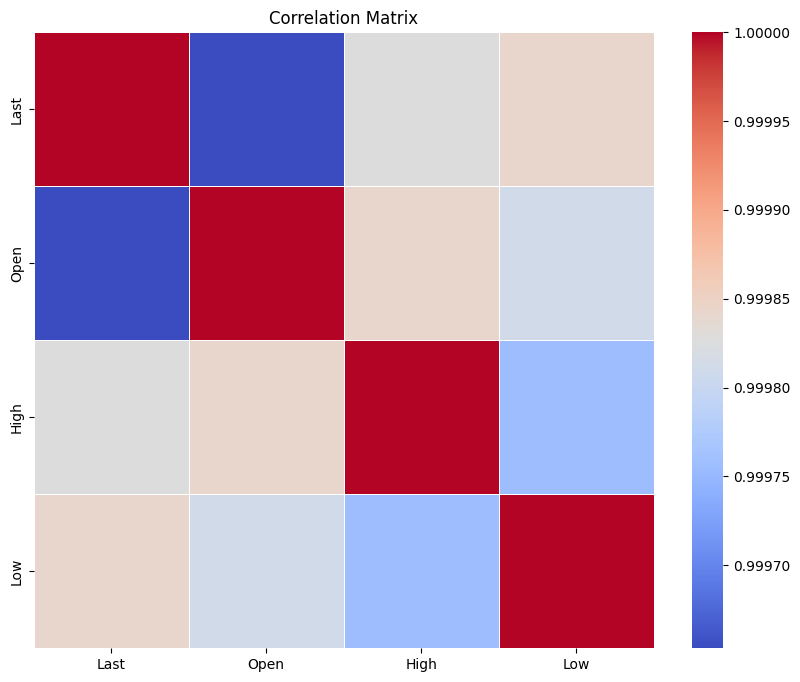

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the independent variables
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [35]:
correlation_matrix

,Last,Open,High,Low
Last,1.000000,0.999653,0.999828,0.999842
Open,0.999653,1.000000,0.999842,0.999810
High,0.999828,0.999842,1.000000,0.999756
Low,0.999842,0.999810,0.999756,1.000000


### All the features are highly Multi-colinear
To avoid it, use PCA for dimentionality reduction


## PCA

In [36]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=1)
pca.fit(train_X.reshape(-1,3))
X_pca_train = pca.transform(train_X.reshape(-1,3))
X_pca_test = pca.transform(test_X.reshape(-1,3))

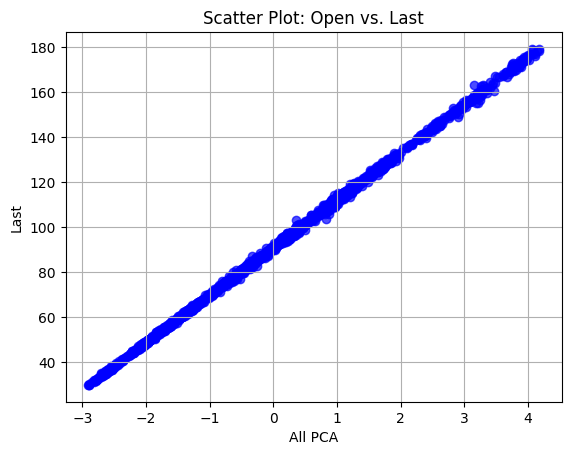

In [46]:
import matplotlib.pyplot as plt

# Scatter plot of Open vs. Last
plt.scatter(X_pca_train, train_y, alpha=0.7, color='blue')
plt.title('Scatter Plot: Open vs. Last')
plt.xlabel('All PCA')
plt.ylabel('Last')
plt.grid(True)
plt.show()

In [74]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


LR = LinearRegression()

# Fit the Linear Regression model
LR.fit(X_pca_train, train_y.reshape(-1, 1))
pred_y = LR.predict(X_pca_test)


mse = mean_squared_error(test_y.reshape(1,-1), pred_y.reshape(1,-1))
mse


5.418601958271938

In [73]:
mae = mean_absolute_error(test_y.reshape(1,-1), pred_y.reshape(1,-1))
mae

2.3236963322896713

In [84]:
r2_score(test_y.reshape(1,-1)[0], pred_y.reshape(1,-1)[0])

-8.94814822870946

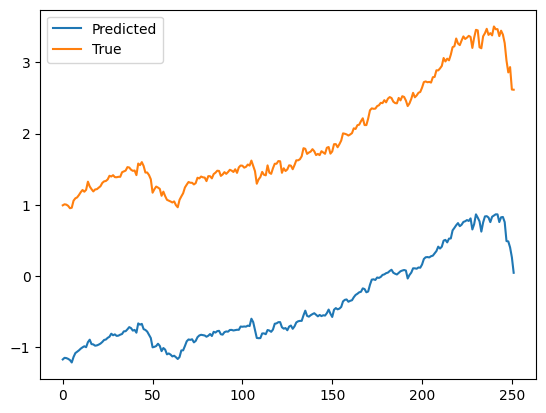

In [68]:
plt.plot(pred_y, label='Predicted')
plt.plot(test_y.reshape(-1,1), label="True")  

plt.legend()

## XGBoost

In [86]:
import xgboost as xgb

# Initialize the XGBoost model
xgb = xgb.XGBRegressor(booster='gblinear' ,objective='reg:squarederror',)

# Train the xgb
xgb.fit(train_X.reshape(-1,3), train_y.reshape(-1))

# Make predictions
predictions = xgb.predict(test_X.reshape(-1,3))

# Evaluate the model
mse = mean_squared_error(test_y.reshape(-1), predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0012422926902874508


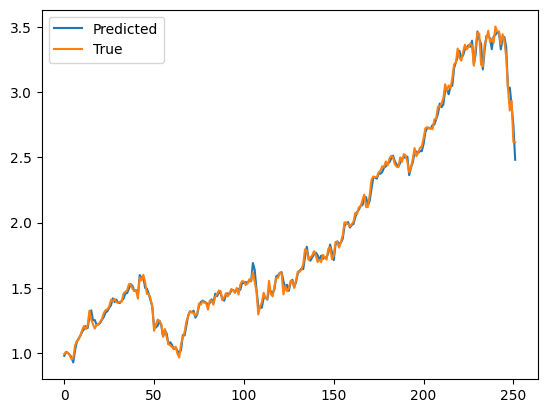

In [87]:
plt.plot(predictions, label='Predicted')
plt.plot(test_y.reshape(-1,1), label="True")  


plt.legend()

## SVR

In [88]:
from sklearn.svm import SVR
regressor = SVR(kernel='linear', C=1.0, gamma='scale')
regressor.fit(X_pca_train, train_y.reshape(-1))

SVR(kernel='linear')

In [89]:
y_pred = regressor.predict(X_pca_test)
# y_pred = sc_y.inverse_transform(y_pred) 
y_pred

array([-1.11124815, -1.0891892 , -1.09313226, -1.10348388, -1.11990227,
       -1.15229453, -1.07811299, -1.0255854 , -1.00628745, -0.98847407,
       -0.96526728, -0.94758313, -0.93333559, -0.94562685, -0.87742707,
       -0.84417289, -0.90373779, -0.90805266, -0.92551921, -0.92121657,
       -0.91071674, -0.89665774, -0.87538052, -0.84799514, -0.84189748,
       -0.81929905, -0.80416322, -0.76324678, -0.78406647, -0.7723518 ,
       -0.7930241 , -0.78907675, -0.77629529, -0.76707883, -0.7310427 ,
       -0.72969446, -0.70380034, -0.67409723, -0.68796463, -0.72139391,
       -0.71176568, -0.74948391, -0.62418305, -0.64062669, -0.63033484,
       -0.7014732 , -0.71240568, -0.73460705, -0.77920268, -0.82140898,
       -0.94747385, -0.94095819, -0.93007128, -0.89877361, -0.92761215,
       -0.99903679, -0.95656468, -0.97828309, -1.04246173, -1.03028452,
       -1.04563716, -1.07022638, -1.0611474 , -1.0813341 , -1.1050738 ,
       -1.07891494, -0.9892176 , -0.9879496 , -0.92939172, -0.86

In [90]:
mse = mean_squared_error(test_y.reshape(1,-1), y_pred.reshape(1,-1))
mse

5.282823579595162

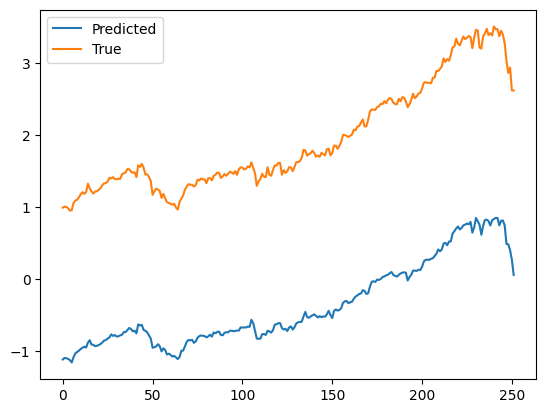

In [91]:
plt.plot(y_pred, label='Predicted')
plt.plot(test_y.reshape(-1), label="True")  

plt.legend()

## RNN

In [92]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD


In [93]:
# Define the model
model = Sequential()


# Define the LSTM layer with the corrected input shape
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
Dropout(0.2),
model.add(LSTM(64, return_sequences=True)) ,
Dropout(0.2),
# model.add(LSTM(10, return_sequences=True)) 
model.add(Dense(1))

/Users/Neha.Duggirala/anaconda3/envs/gen-ai/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])

In [96]:
# Fit the model
history = model.fit(train_X,train_y , validation_data=(val_X, val_y),epochs=100, batch_size=16)

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.3149 - val_accuracy: 0.0000e+00 - val_loss: 0.1553
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0273 - val_accuracy: 0.0000e+00 - val_loss: 0.1244
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0263 - val_accuracy: 0.0000e+00 - val_loss: 0.1185
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0256 - val_accuracy: 0.0000e+00 - val_loss: 0.1003
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0247 - val_accuracy: 0.0000e+00 - val_loss: 0.0756
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0240 - val_accuracy: 0.0000e+00 - val_loss: 0.0745
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0226 - val_accuracy: 0.0000e+00 - val_loss: 0.0797
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 

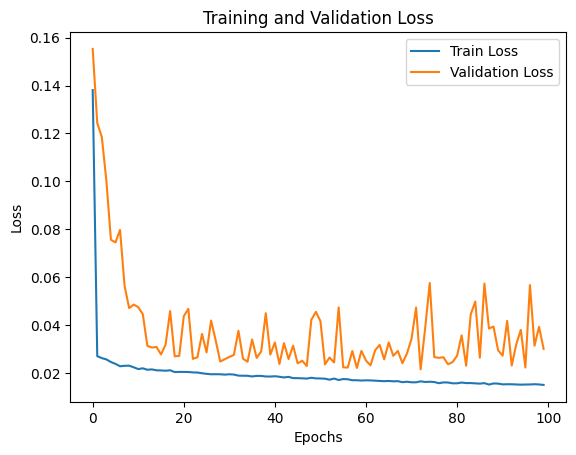

In [97]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [98]:
preicted_y = model.predict(test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


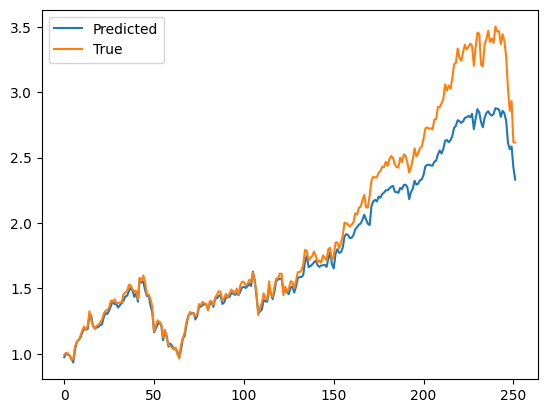

In [99]:
plt.plot(preicted_y.reshape(-1), label='Predicted')
plt.plot(test_y.reshape(-1), label="True")  

plt.legend()

## Grid search

In [23]:
%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 948.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [67]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model as a function for Keras Tuner
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(train_X.shape[1], train_X.shape[2])
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(
            units=hp.Int('units', min_value=50, max_value=200, step=50),
            return_sequences=False
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(1)
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop','sgd']),
        loss=hp.Choice('loss',values = ['mse','rmse'])
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of random combinations to try
    executions_per_trial=1,
    directory='grid_search',
    project_name='lstm_tuning'
)

# Perform the search
tuner.search(train_X, train_y, epochs=50, validation_data=(val_X, val_y), verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from grid_search/lstm_tuning/tuner0.json
Best Hyperparameters: {'units': 100, 'dropout_rate': 0.1, 'optimizer': 'sgd', 'loss': 'mse'}


/Users/Neha.Duggirala/anaconda3/envs/gen-ai/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
